# Audio Effects Classifier Example

To demonstrate how to use the [IDMT-SMT-Audio Effects](https://mirdata.readthedocs.io/en/stable/source/mirdata.html#module-mirdata.datasets.idmt_smt_audio_effects) data loader available in mirdata, this Jupyter notebook goes through the process of training a simple audio effects classifier using the [PyTorch](https://pytorch.org/) framework.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francescopapaleo/mirdata-notebooks/blob/master/idmt_smt_audio_effects/audio_effects_classifier.ipynb)

In [1]:
%pip install mirdata torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
# from google.colab import drive
# drive.mount('/gdrive')

In [3]:
#@title Imports
import os
import shutil
import numpy as np
import mirdata
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

from torch.utils.data import Dataset, DataLoader
from scipy import signal
from torchinfo import summary
from pathlib import Path

print(mirdata.__version__)

0.3.8


In [4]:
# @title Helper functions


def plot_waveform(waveform: np.ndarray, sr: int, title="Waveform", ax=None):
    if waveform.ndim == 2:
        num_channels, num_frames = waveform.shape
    else:
        num_channels, num_frames = 1, waveform.shape[0]

    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots()

    if num_channels == 1:
        ax.plot(time_axis, waveform, linewidth=1)
    else:
        ax.plot(
            time_axis, waveform[0], linewidth=1
        )  # Assuming you want to plot the first channel

    ax.grid(True)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(
    waveform: np.ndarray, sr: int = None, title="Spectrogram", ax=None
):
    if waveform.ndim == 2:
        waveform = waveform[0]  # If stereo, take only the first channel

    # Compute the STFT
    f, t, Zxx = signal.stft(waveform, fs=sr)

    # Convert to magnitude (spectrogram)
    specgram = np.abs(Zxx)

    # Plotting
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot the spectrogram
    ax.imshow(
        20 * np.log10(specgram + 1e-10),
        origin="lower",
        aspect="auto",
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap="inferno",
    )
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_title(title)

    if sr is not None:
        ax.set_ylim(0, sr / 2)  # Limit frequency axis to Nyquist frequency

In [5]:
DATA_HOME = "/Users/francescopapaleo/mir_datasets/idmt_smt_audio_effects/"

In [6]:
#@title Initialize the dataset
idmt_smt_audio_effects = mirdata.initialize("idmt_smt_audio_effects", data_home=DATA_HOME)
print(idmt_smt_audio_effects.data_home)

/Users/francescopapaleo/mir_datasets/idmt_smt_audio_effects/


In [7]:
#@title Download the dataset
# idmt_smt_audio_effects.download(force_overwrite=False, cleanup=True)

In [8]:
#@title Validate the dataset
idmt_smt_audio_effects.validate()

100%|██████████| 55044/55044 [01:40<00:00, 549.99it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

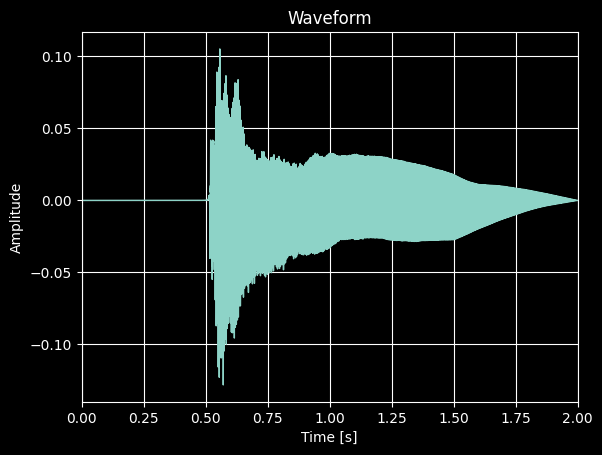

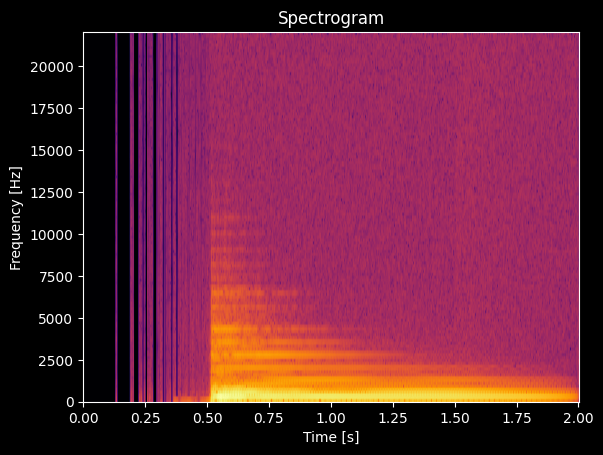

In [9]:
track = idmt_smt_audio_effects.choice_track()
x, sr = track.audio

plot_waveform(x, sr)
plot_spectrogram(x, sr)

In [12]:
class IDMTSMTAudioEffectsDataset(Dataset):
    def __init__(
        self,
        mirdataset,
        train_split=0.8,
        test_split=0.2,
        split_type='train',
        random_seed=23,
        transform=None,
    ):
        self.dataset = mirdataset
        self.transform = transform

        # Set random seed for reproducibility
        torch.manual_seed(random_seed)

        num_tracks = len(self.dataset.track_ids)
        indices = torch.randperm(num_tracks)

        split_index = int(num_tracks * train_split)
        if split_type == 'train':
            selected_indices = indices[:split_index]
        elif split_type == 'test':
            selected_indices = indices[split_index:]
        else:
            raise ValueError("split_type must be 'train' or 'test'")

        # Map the selected indices to track IDs
        self.track_ids = [self.dataset.track_ids[i] for i in selected_indices.tolist()]


    def __getitem__(self, idx):
        track_id = self.track_ids[idx]
        track = self.dataset.track(track_id)

        # Load audio data
        audio_tensor, sr = torchaudio.load(track.audio_path)

        # Apply preprocessing if needed
        if self.transform:
            audio = self.transform(waveform)

        label_map = {
            11: 0,  # No effect
            12: 1,  # No Effect, amplifier simulation
            21: 2,  # Feedback Delay
            22: 3,  # Slapback Delay
            23: 4,  # Reverb
            31: 5,  # Chorus
            32: 6,  # Flanger
            33: 7,  # Phaser
            34: 8,  # Tremolo
            35: 9,  # Vibrato
            41: 10,  # Distortion
            42: 11,  # Overdrive
        }

        label = label_map.get(
            track.fx_type, -1
        )  # Default to -1 if fx_type is not found

        return audio_tensor, label

    def __len__(self):
        return len(self.track_ids)

In [17]:
BATCH_SIZE = 8
NUM_WORKERS = 0

train_dataset = IDMTSMTAudioEffectsDataset(mirdataset=idmt_smt_audio_effects, split_type='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

test_dataset = IDMTSMTAudioEffectsDataset(mirdataset=idmt_smt_audio_effects, split_type='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


Number of training samples: 44035
Number of test samples: 11009


In [34]:
#@title A simple feed-forward classifier

class FeedForwardAudioFxClassifier(nn.Module):
    def __init__(self,
                 input_size: int,       
                 output_size: int = 12, # Number of classes (fx_type)
                 hidden_size: int = 512, # Number of hidden units
                 ):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

ff_model = FeedForwardAudioFxClassifier(input_size=x.shape[0], output_size=12)
summary(ff_model, input_size=(BATCH_SIZE, 1, x.shape[0]))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardAudioFxClassifier             [8, 12]                   --
├─Linear: 1-1                            [8, 512]                  45,159,424
├─Linear: 1-2                            [8, 12]                   6,156
Total params: 45,165,580
Trainable params: 45,165,580
Non-trainable params: 0
Total mult-adds (M): 361.32
Input size (MB): 2.82
Forward/backward pass size (MB): 0.03
Params size (MB): 180.66
Estimated Total Size (MB): 183.52

In [35]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=1):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return epoch_loss


In [36]:
#@title Instantiate the models, loss function and optimizer

NUM_EPOCHS = 1

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam is a good default choice)
ff_optim = torch.optim.Adam(ff_model.parameters(), lr=0.001)
# conv_optim = torch.optim.Adam(conv_model.parameters(), lr=0.001)

# Now, train each model for 1 epoch and compare their performance
loss_ff = train_model(ff_model, train_loader, criterion, ff_optim, num_epochs=NUM_EPOCHS)

print(f"FeedForward Model Loss: {loss_ff}")
# print(f"Convolutional Model Loss: {loss_conv}")

In [28]:
ff_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Forward pass
        outputs = ff_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 27.83%
